# 인물사진 만들기

피사체를 가깝게 찍을 때 배경이 흐려지는 인물사진 모드를 만들어보자.

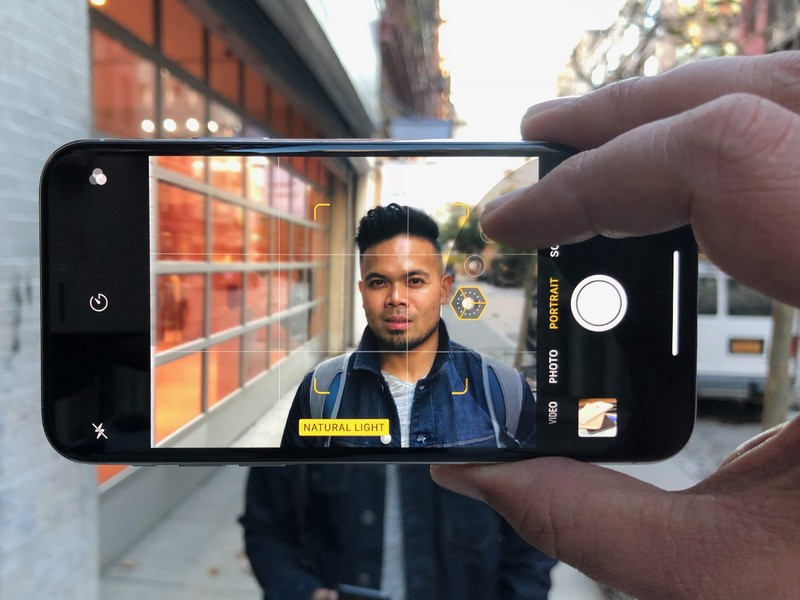

이미지 출처 : https://www.imore.com/how-use-portrait-lighting-without-depth-blur

<br/><br/>

**라이브러리 불러오기**

In [1]:
import cv2
import numpy as np
import os
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'NanumGothic'

from model import DeepLabModel
from info import LABEL_NAMES

<br/>

**이미지 읽기**

In [2]:
def read_image(img_path):
    image = cv2.imread(img_path)
    return image

<br/>

**세그멘테이션 사전학습 모델 불러오기**

In [3]:
def load_model(model_path=None):
    pretrained_path = './models/deeplab_model.tar.gz'
    model = DeepLabModel(pretrained_path)
    return model

<br/>

**크로마키 & 아웃포커싱 결과 보여주기**

In [4]:
def object_mask(image, seg_map, object_index):
    img_mask = np.where(seg_map == object_index, 255, 0).astype(np.uint8) # 특정 Object 부분은 255로 아닌부분은 0으로 만들기
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) 
    
    # 크로마키 사진
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title("크로마키")
    img_mask_for_cromakey = np.where(img_mask_color == 255, image, 220) # 크로마키 배경색 220으로 설정
    plt.imshow(cv2.cvtColor(img_mask_for_cromakey, cv2.COLOR_BGR2RGB))

    # 아웃 포커싱 사진
    img_orig_blur = cv2.blur(image, (13,13)) # (13, 13)범위의 평균값으로 대체한다.
    img_bg_blur = cv2.bitwise_xor(img_orig_blur, img_mask_color) # xor로 계산하면 굳이 not을 하고 and를 할 필요가 없다.
    img_concat = np.where(img_mask_color==255, image, img_bg_blur)
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("아웃 포커싱")
    plt.show()

<br/><br/>

## 고양이 사진

사진과 모델 불러오기

모델에 관해서는 `DeepLabModel` 모델을 사용하고 PascalVOC 2012 데이터를 통해 사전학습된 모델을 사용했습니다. 코드는 [model.py](./model.py)에서 확인하실 수 있습니다.

In [5]:
image = read_image('./images/cat.jpg')

model = load_model()
image, seg_map = model.run(image)

(257, 182)


<br/>모델 결과 확인하기

In [6]:
for index in np.unique(seg_map):
    message = f"Found seg {index} : {LABEL_NAMES[index]}"
    print(message)

Found seg 0 : background
Found seg 8 : cat


<br/>결과를 바탕으로 원하는 객체 크로마키, 아웃포커싱 적용

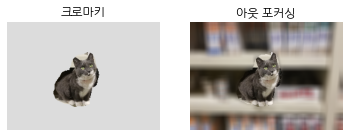

In [7]:
object_mask(image, seg_map, 8)

<br/><br/>

## 인물 사진

In [8]:
image = read_image('./images/jenny.jpeg')

model = load_model()
image, seg_map = model.run(image)

(214, 257)


In [9]:
for index in np.unique(seg_map):
    message = f"Found seg {index} : {LABEL_NAMES[index]}"
    print(message)

Found seg 0 : background
Found seg 15 : person


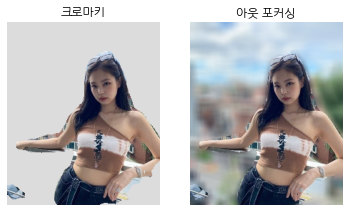

In [10]:
object_mask(image, seg_map, 15)

<br/><br/>

### 인물사진에서의 문제점

사람을 나타내는 영역이 조금 더 넓게 나왔다면 문제가 그리 크지 않다고 생각하는데, 전혀 다른 모서리 부분에서 자동차를 사람으로 인식하였다.

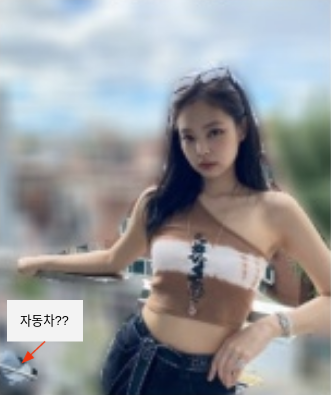

<br/>

### 해결책

너비우선탐색이라 불리는 `BFS`라는 알고리즘을 사용했다. 사람의 영역이라 찾은 곳 안에 사람의 영역이 있고 자동차의 영역이 있는 상황이다. 영역을 구분하는 과정이 필요했다. 좌, 우를 탐색해가며 연결성을 파악하기위해 `BFS`를 사용했다. 이전에 풀었던 [백준-단지번호붙이기](https://www.acmicpc.net/problem/2667) 문제가 문득 떠올랐었다.


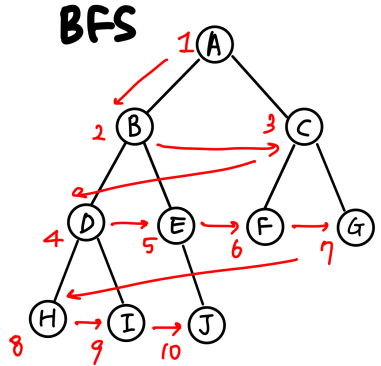

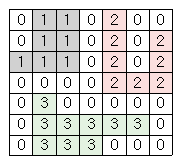

<br/>

**전처리 할 Mask 불러오기**

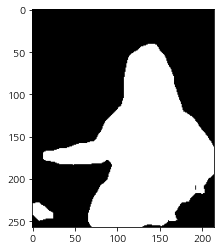

In [11]:
object_index = 15

img_mask = np.where(seg_map == object_index, 255, 0).astype(np.uint8) # 특정 Object 부분은 255로 아닌부분은 0으로 만들기

plt.imshow(img_mask, cmap='gray')

<br/>

**BFS를 통한 영역분할**

특정 영역에 해당될 때마다 값을 부여해서 영역분할을 해야하는데, 영역이 많지 않은 예제다보니 더 나은 시각화를 위해 50으로 구분하였다. 만약 다른 복잡한 이미지로 이를 구현하고자 한다면 다른 방식을 seg_cnt의 증가계수를 줄여야 할 것이다.

In [12]:
import sys
sys.setrecursionlimit(999999)


dx = [-1, 1, 0, 0]
dy = [0, 0, -1, 1]
height, width = img_mask.shape

height, width
cnt = 0
seg_cnt = 50
answer = []
visited = [[False]*width for _ in range(height)]

def dfs(x, y):
    global cnt
    global seg_cnt
    cnt += 1
    visited[x][y] = True

    for i in range(4):
        nx = x + dx[i]
        ny = y + dy[i]

        if nx < 0 or ny < 0 or nx >= height-1 or ny >= width-1:
            continue
        if visited[nx][ny] == False and img_mask[nx][ny] == 255:
            img_mask[nx][ny] = seg_cnt
            dfs(nx, ny)


for i in range(height):
    for j in range(width):
        if img_mask[i][j] == 255 and visited[i][j] == False:
            cnt = 0
            dfs(i, j)
            if cnt != 1:
                answer.append(cnt)
                seg_cnt += 50


<br/>두 영역이 50 색상차이가 있는 것을 확인할 수 있다.

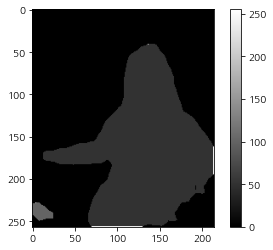

In [13]:
plt.imshow(img_mask, cmap='gray')
_ = plt.colorbar()

특정 인덱스에 접근하여 정확하게 한번 더 확인한다.

In [14]:
img_mask[100][130], img_mask[240][4]

(50, 100)

**내가 얻고자 영역의 index가 무엇인지 알았다면 해당 Mask를 변경하자.**

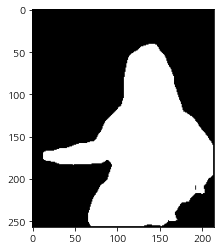

In [15]:
img_mask = np.where(img_mask == 50, 255, 0).astype(np.uint8)
_ = plt.imshow(img_mask, cmap='gray')

**문제점 해결전, 후 결과비교**

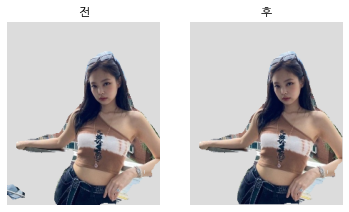

In [16]:
object_index = 15

img_show = image.copy()

# 크로마키 사진
plt.subplot(1,2,2)
plt.axis('off')
plt.title("후")

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_mask_for_cromakey = np.where(img_mask_color == 255, img_show, 220)
plt.imshow(cv2.cvtColor(img_mask_for_cromakey, cv2.COLOR_BGR2RGB))

#########################################

plt.subplot(1,2,1)
plt.axis('off')
plt.title("전")

img_mask = np.where(seg_map == object_index, 255, 0).astype(np.uint8)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_mask_for_cromakey = np.where(img_mask_color == 255, img_show, 220)
plt.imshow(cv2.cvtColor(img_mask_for_cromakey, cv2.COLOR_BGR2RGB))

plt.show()

<br/><br/>

### 회고

작은 문제가 하나 있었다. OpenCV에서 `convex hull`, `cluster`등의 키워드를 통해 해결할 수 있는 듯 하였으나, 불현듯 떠오른 `BFS`라는 알고리즘으로 문제를 해결했다.